#**SMART:¿Cuáles son los atributos musicales, y sus valores, de una canción que más influyen para que esta le guste a un usuario?**

## Información y origen de los datos para la primera aproximación:

Información sobre las variables: [Spotify audio features](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features) 

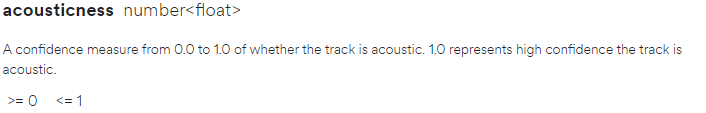

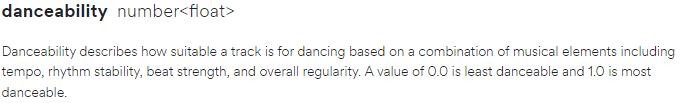

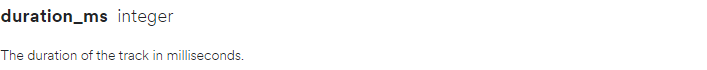

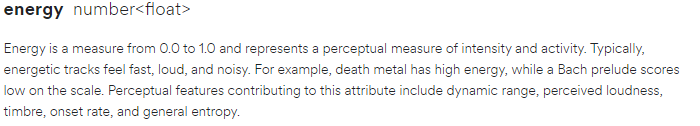

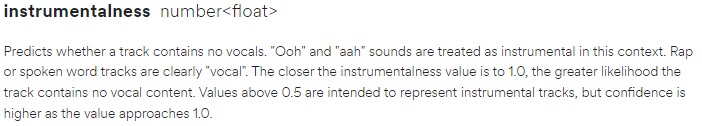

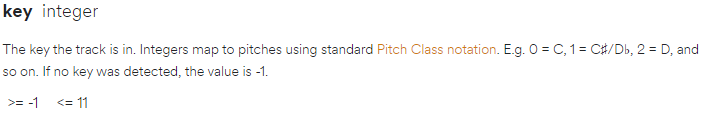

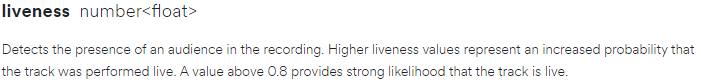

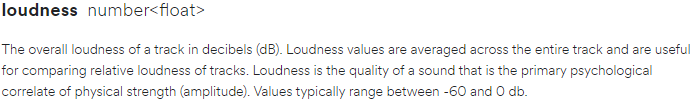

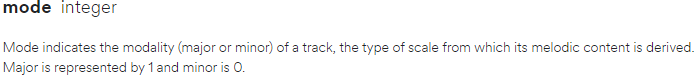

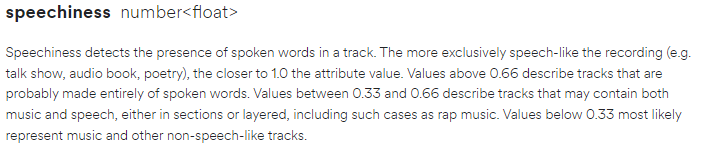

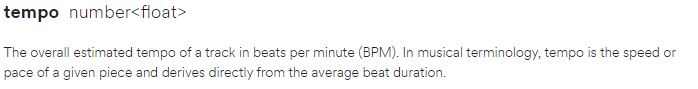

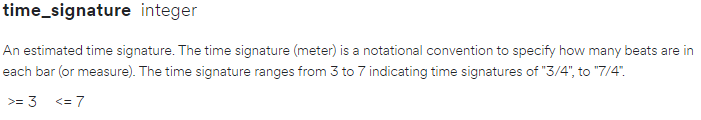

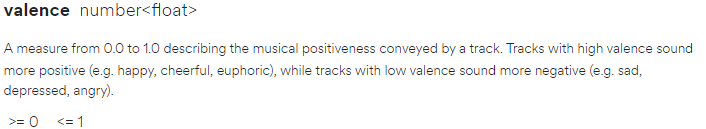

In [2]:
#Librerías de interés.
import os

OMP_NUM_THREADS=1

import pandas as pd                #Importamos la librería pandas. Nos va a servir para leer y manipular conjuntos de datos tabulares.
import matplotlib.pyplot as plt    #Importamos pyplot de librería matplotlib. Lo vamos a utilizar para graficar.
import seaborn as sns              #Importamos la librería Seaborn. La vamos a utilizar para graficar.
import numpy as np                 #Importamos la librería numpy para manipular arreglos. 
#from google.colab import files     #Esta librería nos sirve para cargar archivos desde el disco duro.

from sklearn.model_selection import train_test_split #Útil para dividir los conjuntos de datos. 
from sklearn.preprocessing import MinMaxScaler       #Útil para escalar los atributos de entrada.

from copy import deepcopy                            #Permite hacer copias profundas. 

from sklearn.cluster import KMeans                   #Clase que implementa k-means.
from sklearn.metrics import silhouette_samples       #Útil para calcular el valor de la silueta de una observación. 
from sklearn.metrics import silhouette_score         #Útil para calcular el valor de la silueta de todas las observaciones.
from sklearn.metrics import calinski_harabasz_score  #Útil para calcular el valor del índice Calinski Harabasz (CH).
from sklearn.metrics import confusion_matrix         #Permite extraer la matriz de confusión.

#!pip install yellowbrick --upgrade                   #Instala y actualiza la librería yellowbrick (la versión por defecto en Google Colab está desactualizada).
from yellowbrick.cluster import KElbowVisualizer     #Permite obtener la gráfica del codo para tres métricas diferentes (distorsión, silueta, CH).
from yellowbrick.cluster import SilhouetteVisualizer #Permite obtener la gráfica de las siluetas de cada grupo. 

Fuente de los datos: https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-19212020-600k-tracks

In [7]:
df = pd.read_csv('data\dataset.csv',na_values='?') 

#**Análisis Exploratorio de los Datos**

## **Limpieza - Preparación**

---



**Cantidad de observaciones y atributos**

In [8]:
#Miramos la cantidad de observaciones (filas) y atributos (columnas) y la variable target
num_rows, num_cols = df.shape
print("Este dataset cuenta con {} observaciones y {} atributos.".format(num_rows, num_cols))

Este dataset cuenta con 200000 observaciones y 20 atributos.


**Descripción del dataset**

In [9]:
#Descripción general del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                200000 non-null  object 
 1   name              199985 non-null  object 
 2   popularity        200000 non-null  int64  
 3   duration_ms       200000 non-null  int64  
 4   explicit          200000 non-null  int64  
 5   artists           200000 non-null  object 
 6   id_artists        200000 non-null  object 
 7   release_date      200000 non-null  object 
 8   danceability      200000 non-null  float64
 9   energy            200000 non-null  float64
 10  key               200000 non-null  int64  
 11  loudness          200000 non-null  float64
 12  mode              200000 non-null  int64  
 13  speechiness       200000 non-null  float64
 14  acousticness      200000 non-null  float64
 15  instrumentalness  200000 non-null  float64
 16  liveness          20

**Previsualización del dataset**

In [10]:
df.tail()

id                    name  popularity  \
199995  624KxqlETNp4wgp2Puz2t5                 Oliver!           8   
199996  3F8aTQzmKovktFcR7MCGFW  Big in Japan - Best Of          60   
199997  4MESZOnrILVKOrBEGmB8EE        Midnight Rambler          19   
199998  0dJe4Ft1gyODsMTpLmY6p9          Upon This Rock          19   
199999  1O8gtsPns1kEY388oQ9F8S            Karar Verdim          34   

        duration_ms  explicit  \
199995       105240         0   
199996       235200         0   
199997       412760         0   
199998       309670         0   
199999       260107         0   

                                                  artists  \
199995  ['Lionel Bart', 'Paul Whitsun-Jones', 'Hope Ja...   
199996                                     ['Alphaville']   
199997                             ['The Rolling Stones']   
199998                                    ['Sandi Patty']   
199999                                        ['Nilüfer']   

                                               id_artists release_date  \
199995  ['1smSmZepUggfE5CxLLghtw', '5g1hS4IWjPdfUh8ILp...   1960-01-01   
199996                         ['0xliTEbFfy5HQHvsTknTkX']   1991-12-17   
199997                         ['22bE4uQ6baNwSHPVcDxLCe']   1969-12-05   
199998                         ['6RJYPm4gcrIuOjQiqu9VXu']   1989-11-06   
199999                         ['3iVIrcJmrV7GawrxVWsBUF']   2007-12-17   

        danceability  energy  key  loudness  mode  speechiness  acousticness  \
199995         0.596   0.288    1   -16.843     1       0.5350         0.723   
199996         0.755   0.604    2    -9.840     0       0.0454         0.183   
199997         0.489   0.658    4   -10.287     1       0.0866         0.776   
199998         0.338   0.531    0   -10.568     0       0.1030         0.753   
199999         0.727   0.876    7    -6.969     0       0.1430         0.156   

        instrumentalness  liveness  valence    tempo  time_signature  
199995          0.000000     0.328    0.662  102.177               4  
199996          0.033600     0.128    0.491   97.800               4  
199997          0.000003     0.243    0.551  129.006               4  
199998          0.000017     0.717    0.160  129.599               4  
199999          0.000005     0.104    0.599   92.941               4

In [11]:
#Eliminaremos la columna "id" y "id_artists" pues es no aportan  información relevamente al momento de entrenar el modelo
df_clean = df.drop(["id", "id_artists"], axis=1)

In [12]:
#Visualizamos nuevamente el dataframe para verificar los cambios realizados
df_clean.head()

name  popularity  duration_ms  \
0                      Дети проходных дворов          21       105015   
1                                         95          37       234800   
2                            As almal ver is          10       147733   
3        Il tuo mondo (Nono, dobri moj nono)          29       194373   
4  Bazaar - Official Sunburn Goa 2015 Anthem          55       172500   

   explicit              artists release_date  danceability  energy  key  \
0         0             ['Kino']   1985-01-01         0.890  0.6680    9   
1         0     ['Picture This']   2017-08-25         0.663  0.5510    1   
2         0  ['Koos Du Plessis']         1992         0.376  0.0979    2   
3         0    ['Claudio Villa']         1969         0.565  0.3270    5   
4         0  ['KSHMR', 'Marnik']   2015-12-25         0.582  0.9790   11   

   loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0   -10.044     0       0.0533         0.570          0.000002    0.0591   
1    -6.445     1       0.0280         0.697          0.000000    0.1800   
2   -18.280     1       0.0350         0.485          0.000577    0.1150   
3   -13.843     1       0.0295         0.781          0.000011    0.1310   
4    -2.492     0       0.0714         0.125          0.001520    0.3390   

   valence    tempo  time_signature  
0    0.942  137.934               4  
1    0.339  128.992               4  
2    0.236   90.290               3  
3    0.556  103.256               3  
4    0.196  128.010               4

##**Análisis univariado**

In [13]:
#Mostramos algunos datos generales del dataset
df_clean.describe()

popularity   duration_ms       explicit   danceability  \
count  200000.000000  2.000000e+05  200000.000000  200000.000000   
mean       27.602885  2.299969e+05       0.044040       0.563697   
std        18.346703  1.255230e+05       0.205185       0.166163   
min         0.000000  4.000000e+03       0.000000       0.000000   
25%        13.000000  1.752698e+05       0.000000       0.453000   
50%        27.000000  2.149070e+05       0.000000       0.577000   
75%        41.000000  2.637600e+05       0.000000       0.686000   
max       100.000000  4.864333e+06       1.000000       0.988000   

              energy            key       loudness           mode  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.542630       5.220840     -10.199316       0.658550   
std         0.251919       3.519135       5.090286       0.474197   
min         0.000000       0.000000     -60.000000       0.000000   
25%         0.345000       2.000000     -12.882000       0.000000   
50%         0.550000       5.000000      -9.225000       1.000000   
75%         0.749000       8.000000      -6.482000       1.000000   
max         1.000000      11.000000       4.584000       1.000000   

         speechiness   acousticness  instrumentalness       liveness  \
count  200000.000000  200000.000000     200000.000000  200000.000000   
mean        0.104344       0.448605          0.112298       0.213165   
std         0.178580       0.348632          0.265402       0.183844   
min         0.000000       0.000000          0.000000       0.000000   
25%         0.034000       0.096100          0.000000       0.098000   
50%         0.044300       0.420000          0.000024       0.138000   
75%         0.076200       0.783000          0.009090       0.276000   
max         0.971000       0.996000          1.000000       1.000000   

             valence          tempo  time_signature  
count  200000.000000  200000.000000   200000.000000  
mean        0.552462     118.551420        3.872770  
std         0.257783      29.783307        0.474314  
min         0.000000       0.000000        0.000000  
25%         0.346000      95.675750        4.000000  
50%         0.564000     117.518500        4.000000  
75%         0.769000     136.545000        4.000000  
max         1.000000     246.381000        5.000000

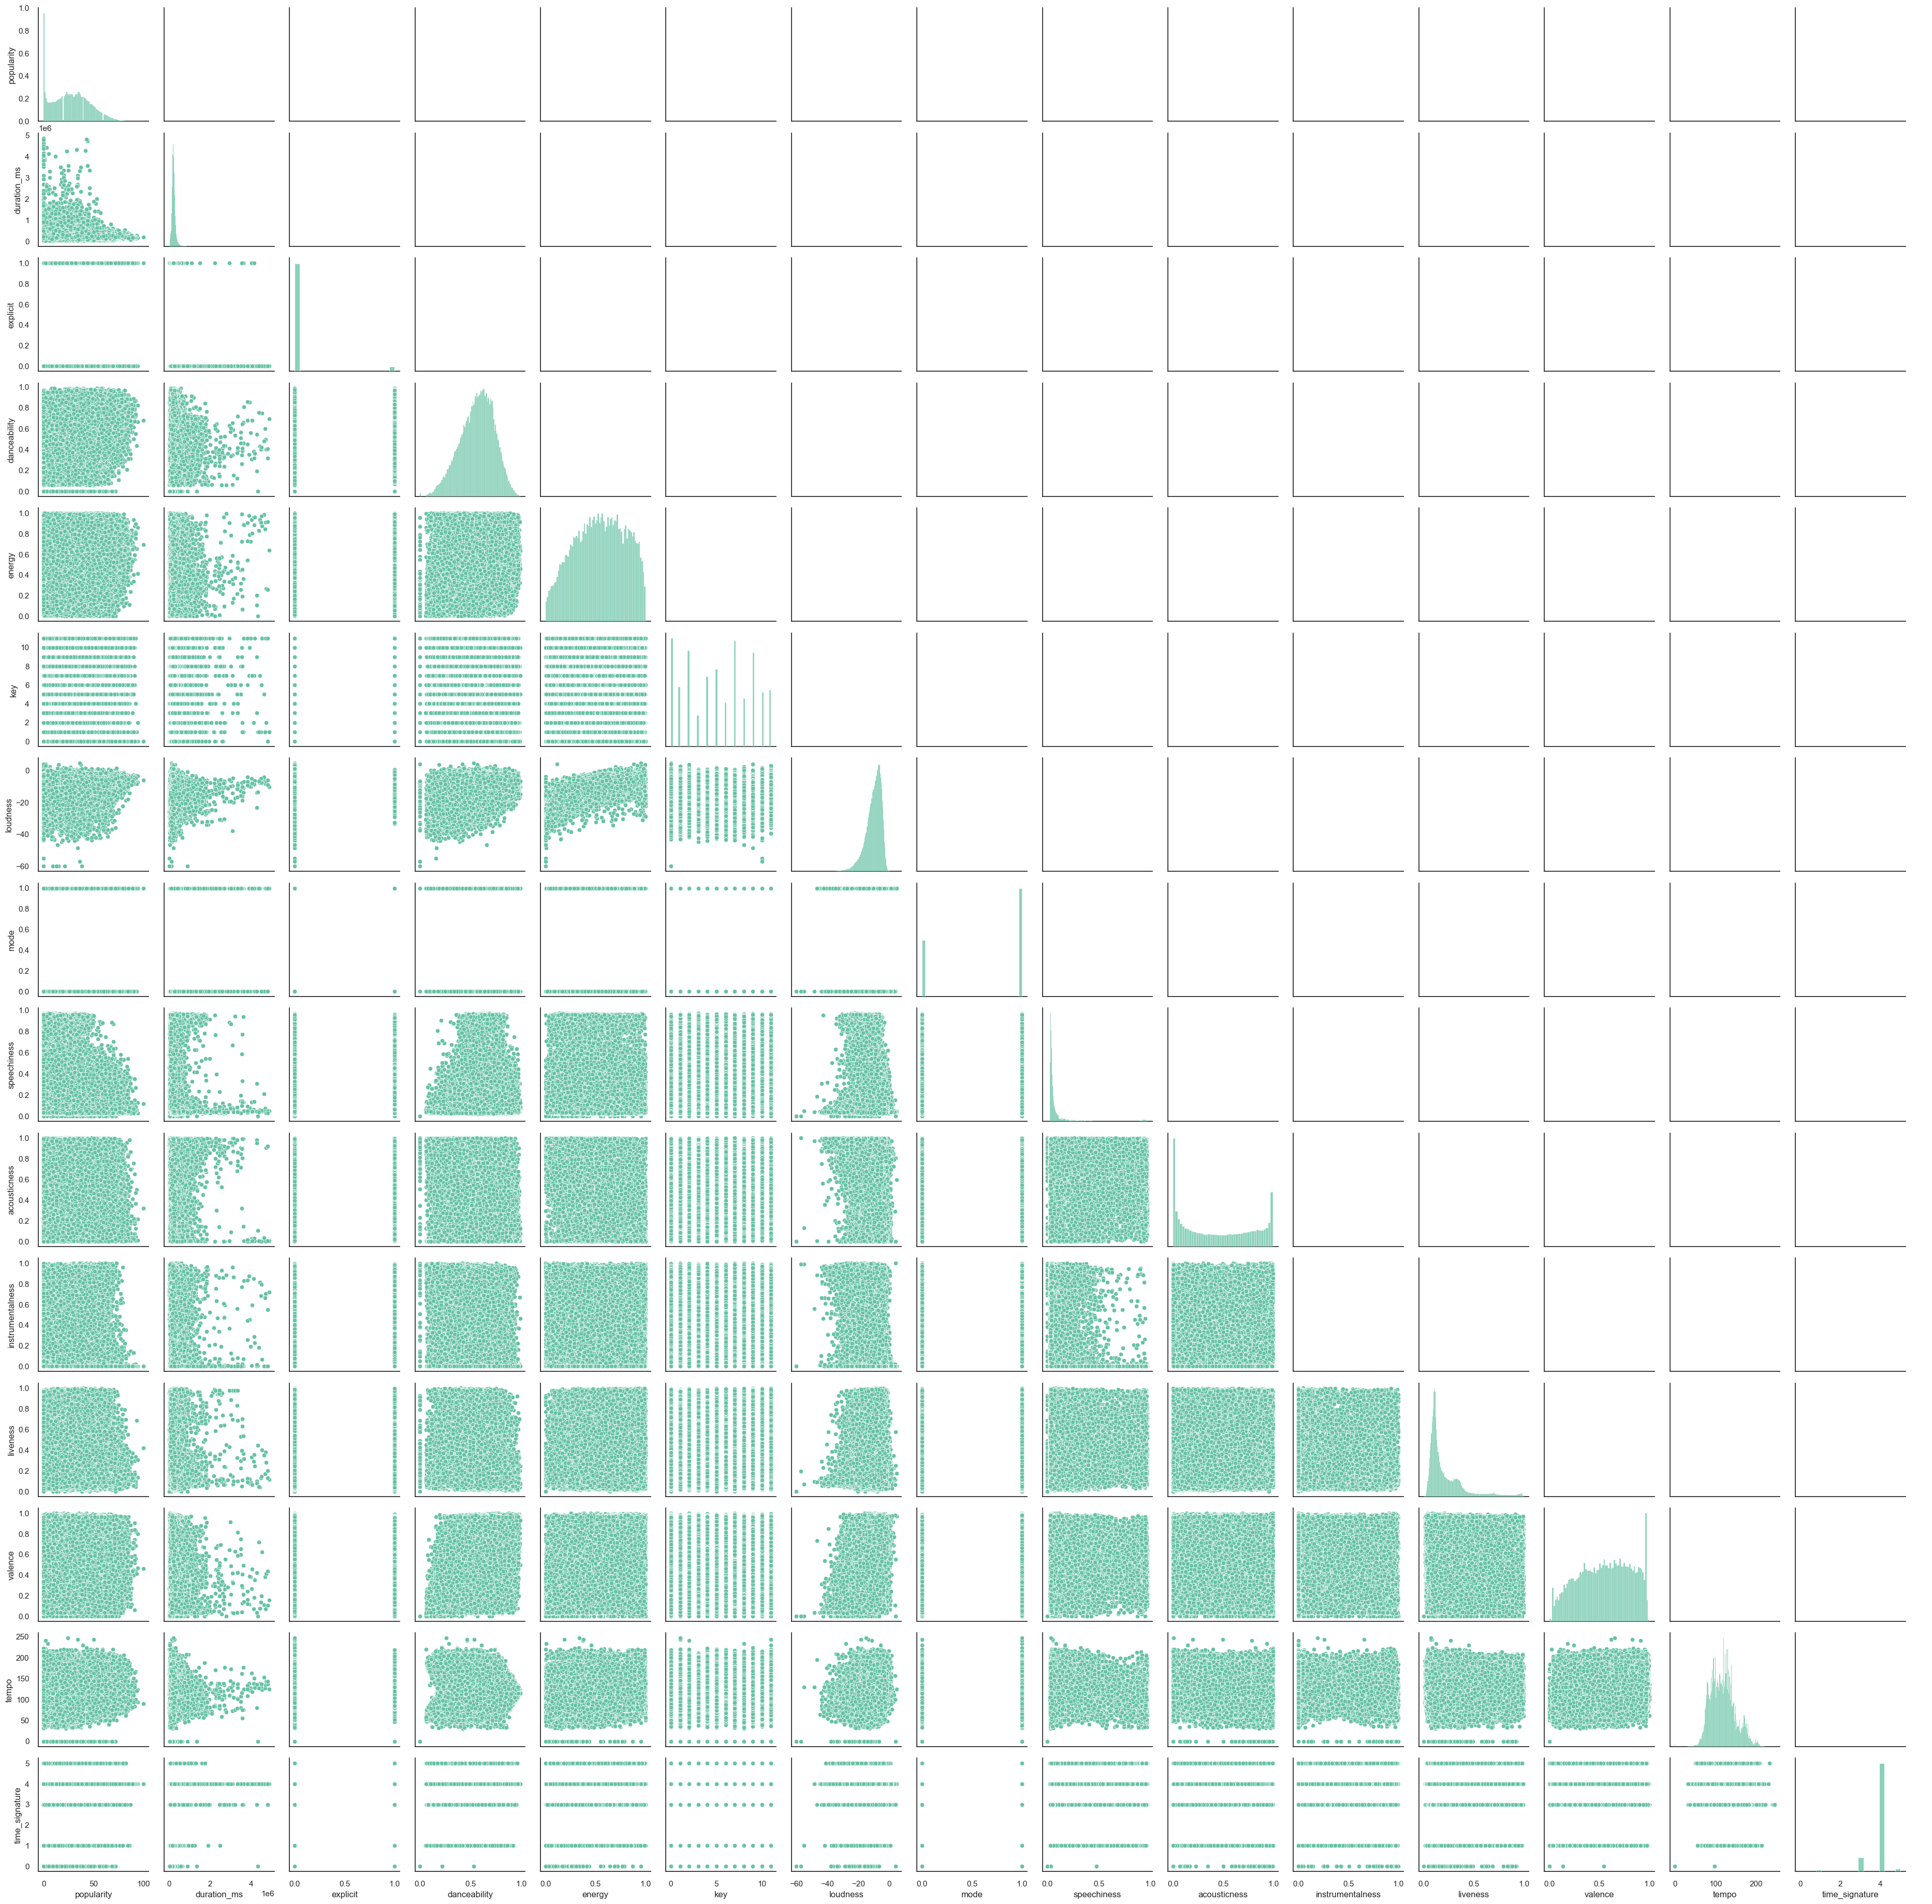

In [14]:
sns.set(style='white')
sns.set_palette('Set2')

g = sns.PairGrid(data=df_clean,diag_sharey=False, corner=False)

g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot)

g.add_legend()
plt.show()

In [15]:
#Validamos que efectivamente ya no existan los datos repetidos
df_clean.duplicated().sum()

214

**Observaciones:** En este caso se encuentran valores repetidos en el dataser, pero no los eliminaremos porque en el contexto de nuestro problema es posible que existan canciones con valores iguales para alguno de sus atributos.

In [16]:
#Ahora, revisamos si el dataset original cuenta con valores nulos
df_clean.isnull().sum()

name                15
popularity           0
duration_ms          0
explicit             0
artists              0
release_date         0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
time_signature       0
dtype: int64

**Observaciones:** En este caso vemos que se identificaron 15 nulos en el atributo name. Decidimos eliminarlos pues el nombre es un atributo significativo para identificar una canción, ya que ahora mismo no contamos con el atributo id de la canción (lo eliminamos en pasos anteriores).

In [17]:
#Utilizamos el método dropna para eliminar los nulos del dataset
df_clean = df_clean.dropna()

In [18]:
#Ahora, contamos los nulos nuevamente para verificar los cambios
df_clean.isnull().sum()

name                0
popularity          0
duration_ms         0
explicit            0
artists             0
release_date        0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
dtype: int64

In [19]:
df_clean.plot(kind = 'box', subplots = True, figsize= (20,20), layout = (4,4))

popularity             AxesSubplot(0.125,0.712609;0.168478x0.167391)
duration_ms         AxesSubplot(0.327174,0.712609;0.168478x0.167391)
explicit            AxesSubplot(0.529348,0.712609;0.168478x0.167391)
danceability        AxesSubplot(0.731522,0.712609;0.168478x0.167391)
energy                 AxesSubplot(0.125,0.511739;0.168478x0.167391)
key                 AxesSubplot(0.327174,0.511739;0.168478x0.167391)
loudness            AxesSubplot(0.529348,0.511739;0.168478x0.167391)
mode                AxesSubplot(0.731522,0.511739;0.168478x0.167391)
speechiness             AxesSubplot(0.125,0.31087;0.168478x0.167391)
acousticness         AxesSubplot(0.327174,0.31087;0.168478x0.167391)
instrumentalness     AxesSubplot(0.529348,0.31087;0.168478x0.167391)
liveness             AxesSubplot(0.731522,0.31087;0.168478x0.167391)
valence                    AxesSubplot(0.125,0.11;0.168478x0.167391)
tempo                   AxesSubplot(0.327174,0.11;0.168478x0.167391)
time_signature          AxesSubplo

**Observaciones:** En el gráfico anterior podemos ver que el dataset cuenta con muchos outliers en varios de los atributos. Sin embargo, decidimos mantener estos datos atípicos pues consideramos que aunque los valores puedan ser extraños pueden aportar información para determinar si una canción puede o no gustarle a un usuario.

# 3. Modelo

In [20]:
#En este parte escogemos los atributos con los que vamos a entrenar el modelo:
nombre_de_las_variables_de_entrada = ['danceability','speechiness','instrumentalness']

#Ahora, obtenemos un dataframe con las variables de entrada que vamos a utilizar.
df_x = deepcopy(df_clean[nombre_de_las_variables_de_entrada])

In [21]:
rango_de_salida_de_las_variables_escaladas = (0,1)  #Tupla con el siguiente formato: (mínimo deseado, máximo deseado).
scaler = MinMaxScaler(feature_range=rango_de_salida_de_las_variables_escaladas)  #Instanciamos el objeto para escalar los datos. 

df_x_norm = deepcopy(df_x)  #Inicializamos este objeto con una copia profunda del las columnas de entrada de interés del dataframe.
df_x_norm[nombre_de_las_variables_de_entrada] = scaler.fit_transform(df_x) #Ajustamos y transformamos los datos.

print('-----------------------------------------------------------------------')
print('Datos de entrada del conjunto de entrenamiento ANTES del escalado')
print('-----------------------------------------------------------------------')
print(df_x.describe(),'\n')

print('-----------------------------------------------------------------------')
print('Datos de entrada del conjunto de entrenamiento DESPUÉS del escalado')
print('-----------------------------------------------------------------------')
print(df_x_norm.describe())

-----------------------------------------------------------------------
Datos de entrada del conjunto de entrenamiento ANTES del escalado
-----------------------------------------------------------------------
       danceability    speechiness  instrumentalness
count  199985.00000  199985.000000     199985.000000
mean        0.56371       0.104348          0.112293
std         0.16616       0.178586          0.265401
min         0.00000       0.000000          0.000000
25%         0.45300       0.034000          0.000000
50%         0.57700       0.044300          0.000024
75%         0.68600       0.076200          0.009080
max         0.98800       0.971000          1.000000 

-----------------------------------------------------------------------
Datos de entrada del conjunto de entrenamiento DESPUÉS del escalado
-----------------------------------------------------------------------
        danceability    speechiness  instrumentalness
count  199985.000000  199985.000000     19998

In [22]:
# Vamos a dividir los datos en un conjunto de entrenamiento y un conjunto de pruebas.
mezclar_los_datos       = True #Vamos a mezclar de forma aleatoria los datos antes de particionarlos. 
valor_semilla_aleatoria = 42   #Esto es útil si se quiere garantizar la repetibilidad 
                               #de la partición de datos en ejecuciones sucesivas de su notebook o script.
particion_para_pruebas = 0.2

#Hacemos la partición para obtener el conjunto de pruebas y el "resto" (i.e.: entrenamiento y desarrollo).
df_x_train, df_x_test = train_test_split(df_x_norm,                                         #100% de los datos de entrada. 
                                                              test_size=particion_para_pruebas, 
                                                              random_state=valor_semilla_aleatoria, 
                                                              shuffle=mezclar_los_datos)

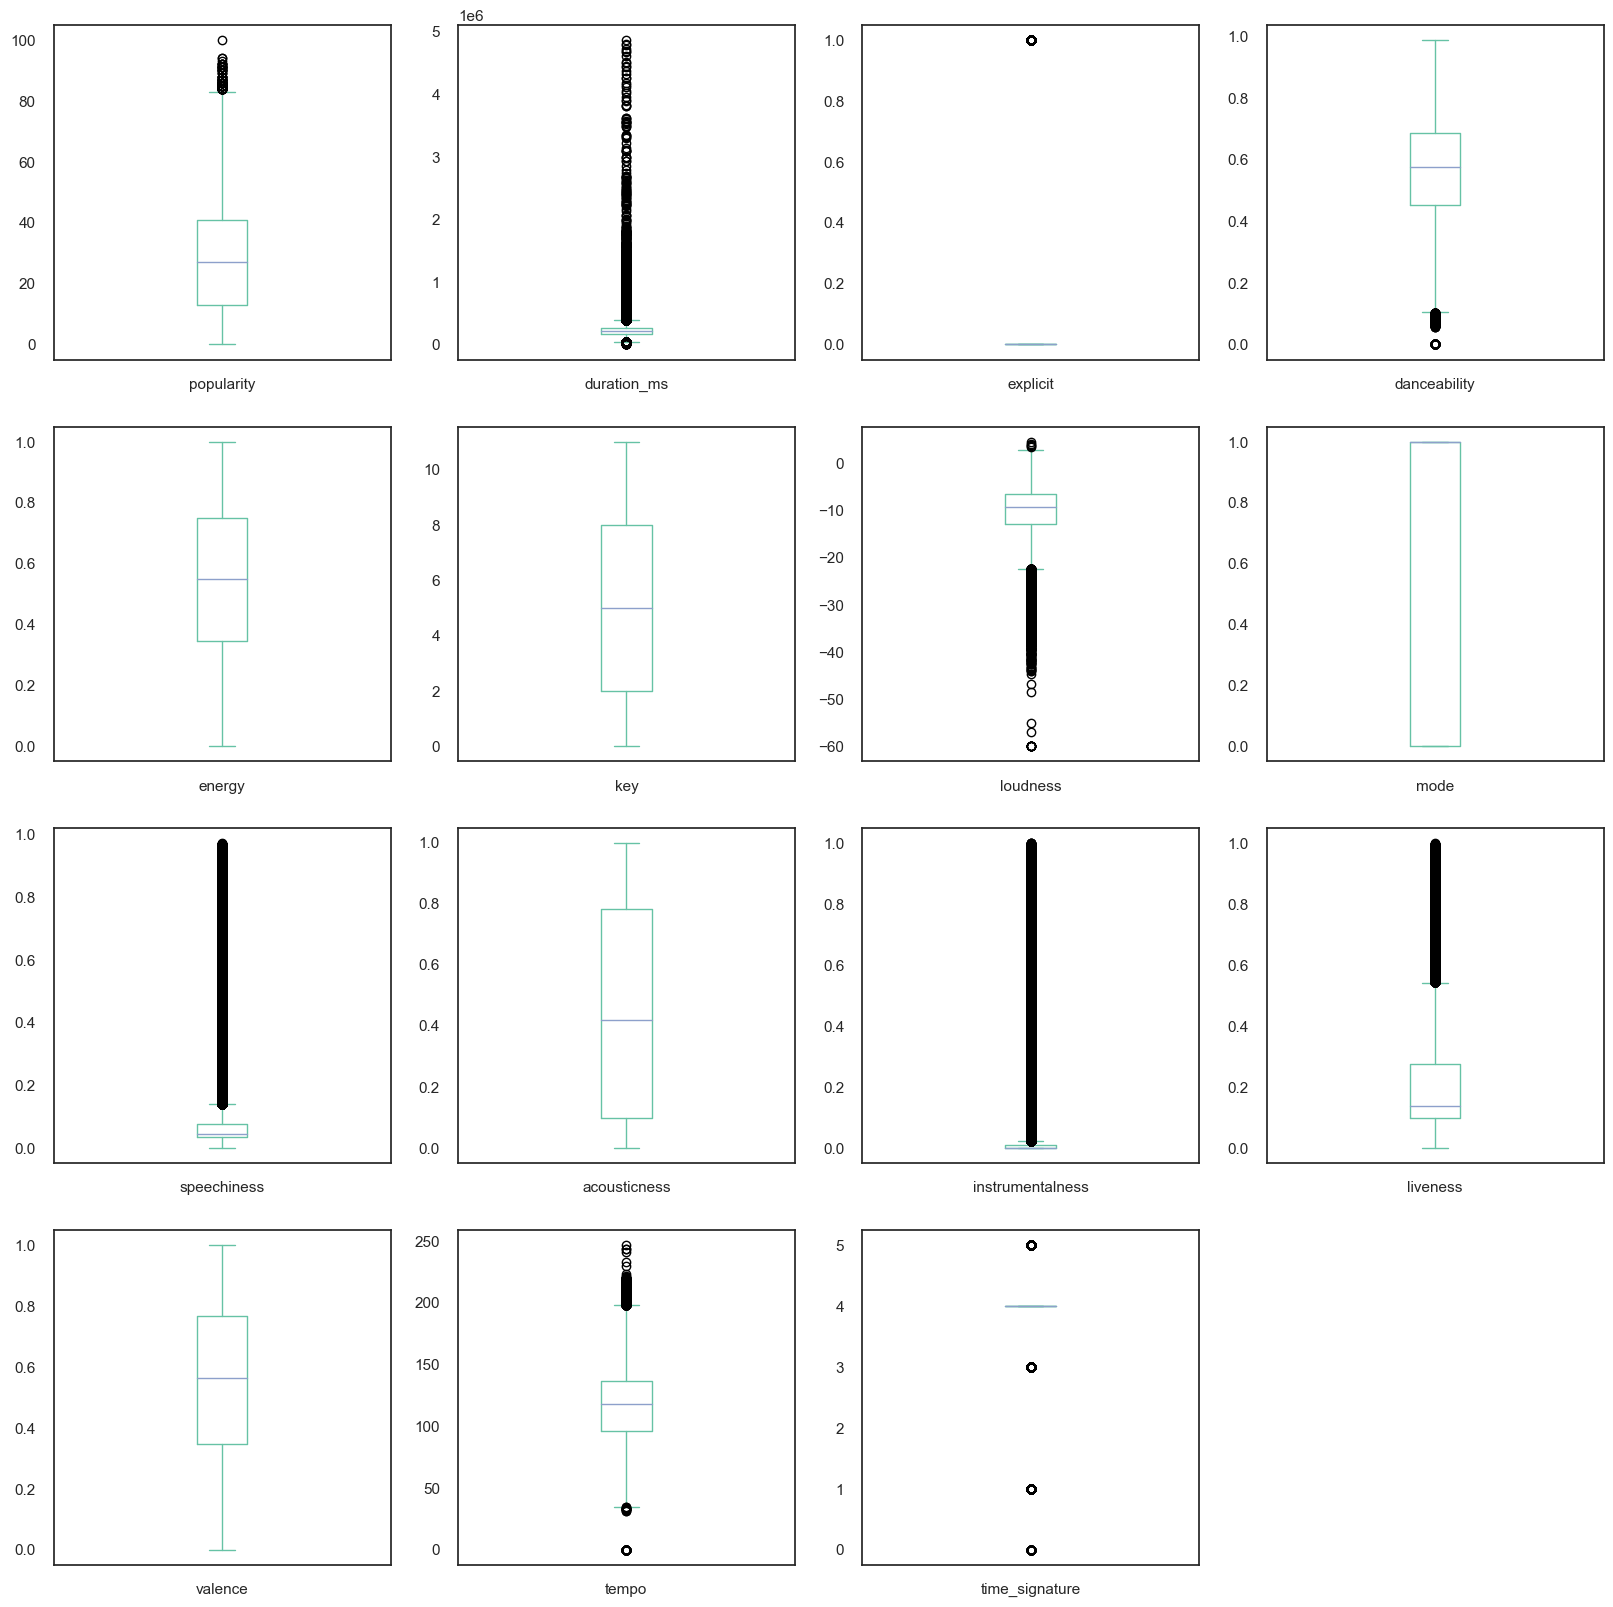

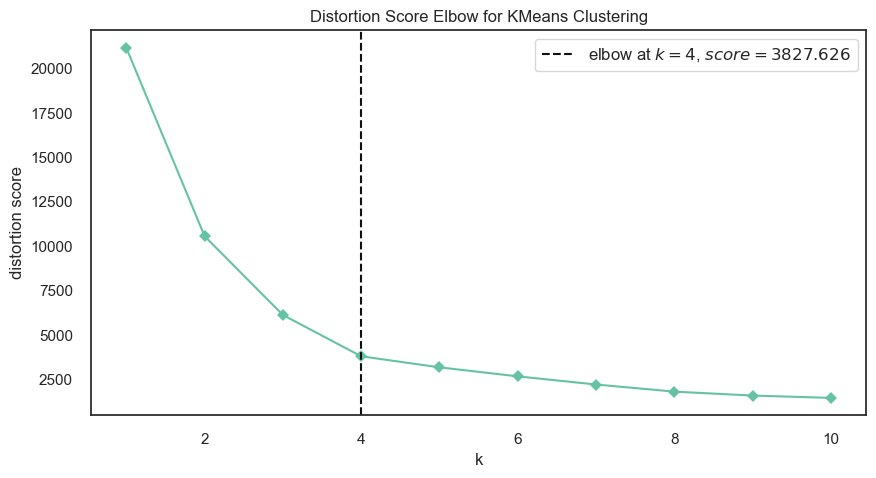

KeyboardInterrupt: 

In [23]:
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
# HYPERPARÁMETROS DEL MODELO
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------

kmin              = 1           #Límite inferior para explorar el número de grupos.
kmax              = 10          #Límite superior para explorar el número de grupos.
init              ='k-means++'  #Se define el método de inicialización. Otra opción válida es 'random'.
n_init            = 10          #Número de inicializaciones aleatorias. Al final scikit learn escoge aquel con la menor inercia 
                                #(i.e.: suma de cuadrados de distancias de cada punto a su centroide respectivo dentro de cada grupo, para todos los puntos). 
                                #https://scikit-learn.org/stable/modules/clustering.html
max_iter          = 300         #Número MÁXIMO de iteraciones para una sola ejecución.
random_seed       = 42          #Semilla aleatoria. Permite obtener los mismos resultados en cada ejecución.


model2 = KMeans(init=init,              #Se define el método de inicialización. 
               n_init=n_init,           #Número de inicializaciones aleatorias. Al final se escoge aquel con la menor inercia: sum( (x_i-centroide(x_i))^2 ). 
               max_iter=max_iter,       #Número MÁXIMO de iteraciones para una sola ejecución.
               random_state=random_seed)

for metric in ["distortion", "silhouette", "calinski_harabasz"]:  #Itere sobre las métricas que soporta KElbowVisualizer.
  
  #Este condicional permite adaptar el flujo pues dos de las métricas requieren al menos 2 grupos para que se puedan calcular.
  if metric=="silhouette" or metric=="calinski_harabasz":  
    kmin_ = max(2,kmin)
  else:
    kmin_ = kmin
  
  plt.figure(figsize=(10,5))   #Tamaño de la figura (ancho, alto).
  visualizer2 = KElbowVisualizer(estimator=model2, 
                                  k=(kmin_,kmax+1),     #Permite explorar valores de k entre [kmin_,kmax].
                                  metric=metric,        #Opciones:  "distortion", "silhouette", "calinski_harabasz"
                                  timings=False,          
                                  locate_elbow=True)   #Si esta opción se activa, ubica el codo con una línea punteada.
  visualizer2.fit(df_x_train)   #Ajusta los datos al visualizador.
  visualizer2.show()

In [ ]:
#-------------------------------------------------------------------------------
#K-means
#-------------------------------------------------------------------------------
k = 4  #Número de grupos que se escogió después del análisis previo.

#Ahora se instancia el objeto para utilizar el agrupamiento con k-means.
#Para ver todas los opciones del constructor, consulte: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
#Nota: el algoritmo de k-means disponible en scikit-learn funciona únicamente con la distancia euclidiana.
#Si requiere aplicar k-means con otras métricas de distancia, puede consultar la librería PyClustering: https://github.com/annoviko/pyclustering
kmeans = KMeans(n_clusters   = k,            #Se define el número de grupos.
                init         = init,         #Se define el método de inicialización. Otra opción es 'random'
                n_init       = n_init,       #Número de inicializaciones aleatorias. 
                max_iter     = max_iter,     #Número MÁXIMO de iteraciones para una sola ejecución.
                random_state = random_seed)

#Hagamos el ajuste (i.e.: encontremos los centroides).
kmeans.fit(df_x_train)

#Revisemos los centroides de cada grupo.
centroides = kmeans.cluster_centers_
print('Centroides:', centroides)

Centroides: [[0.69569435 0.08400852 0.01424399]
 [0.67267826 0.8782623  0.00251058]
 [0.47684013 0.06236987 0.78842255]
 [0.43031187 0.05849415 0.02175959]]


In [24]:
#Grafiquemos las observaciones y los centroides de cada grupo.
plt.figure(figsize=(5,5))
plt.scatter(df_x_train.iloc[:,0],   df_x_train.iloc[:,1], c=kmeans.labels_.reshape((-1,1)), s=50,  cmap='viridis')  #Observaciones.
plt.scatter(centroides[:, 0], centroides[:, 1], marker='o', color='white', edgecolor='k', s=300, alpha=0.8)       #Centroides.
plt.xlabel(df_x_train.columns[0]+' normalizado.')
plt.ylabel(df_x_train.columns[1]+' normalizado.')

#Esto permite identificar cada centroide con su índice asociado. 
for i, c in enumerate(centroides):
  plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

plt.title('Resultado del agrupamiento')
plt.show()

NameError: name 'kmeans' is not defined

In [32]:
#En este parte escogemos los atributos con los que vamos a entrenar el modelo:
nombre_de_las_variables_de_entrada = ['danceability','speechiness']

#Ahora, obtenemos un dataframe con las variables de entrada que vamos a utilizar.
df_x = deepcopy(df_clean[nombre_de_las_variables_de_entrada])

In [33]:
rango_de_salida_de_las_variables_escaladas = (0,1)  #Tupla con el siguiente formato: (mínimo deseado, máximo deseado).
scaler = MinMaxScaler(feature_range=rango_de_salida_de_las_variables_escaladas)  #Instanciamos el objeto para escalar los datos. 

df_x_norm = deepcopy(df_x)  #Inicializamos este objeto con una copia profunda del las columnas de entrada de interés del dataframe.
df_x_norm[nombre_de_las_variables_de_entrada] = scaler.fit_transform(df_x) #Ajustamos y transformamos los datos.

print('-----------------------------------------------------------------------')
print('Datos de entrada del conjunto de entrenamiento ANTES del escalado')
print('-----------------------------------------------------------------------')
print(df_x.describe(),'\n')

print('-----------------------------------------------------------------------')
print('Datos de entrada del conjunto de entrenamiento DESPUÉS del escalado')
print('-----------------------------------------------------------------------')
print(df_x_norm.describe())

-----------------------------------------------------------------------
Datos de entrada del conjunto de entrenamiento ANTES del escalado
-----------------------------------------------------------------------
       danceability    speechiness
count  199985.00000  199985.000000
mean        0.56371       0.104348
std         0.16616       0.178586
min         0.00000       0.000000
25%         0.45300       0.034000
50%         0.57700       0.044300
75%         0.68600       0.076200
max         0.98800       0.971000 

-----------------------------------------------------------------------
Datos de entrada del conjunto de entrenamiento DESPUÉS del escalado
-----------------------------------------------------------------------
        danceability    speechiness
count  199985.000000  199985.000000
mean        0.570556       0.107465
std         0.168178       0.183919
min         0.000000       0.000000
25%         0.458502       0.035015
50%         0.584008       0.045623
75%      

In [36]:
# Vamos a dividir los datos en un conjunto de entrenamiento y un conjunto de pruebas.
mezclar_los_datos       = True #Vamos a mezclar de forma aleatoria los datos antes de particionarlos. 
valor_semilla_aleatoria = 42   #Esto es útil si se quiere garantizar la repetibilidad 
                               #de la partición de datos en ejecuciones sucesivas de su notebook o script.
particion_para_pruebas = 0.8

#Hacemos la partición para obtener el conjunto de pruebas y el "resto" (i.e.: entrenamiento y desarrollo).
df_x_train, df_x_test = train_test_split(df_x_norm,                                         #100% de los datos de entrada. 
                                                              test_size=particion_para_pruebas, 
                                                              random_state=valor_semilla_aleatoria, 
                                                              shuffle=mezclar_los_datos)

<Figure size 1000x500 with 0 Axes>

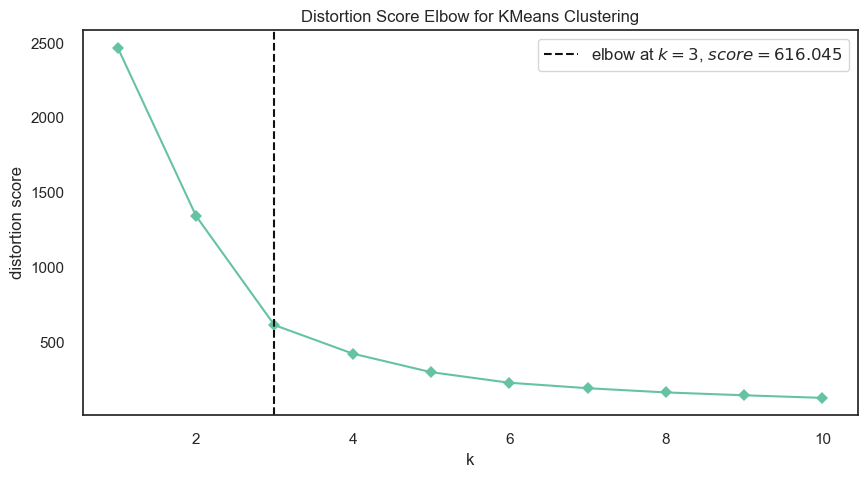

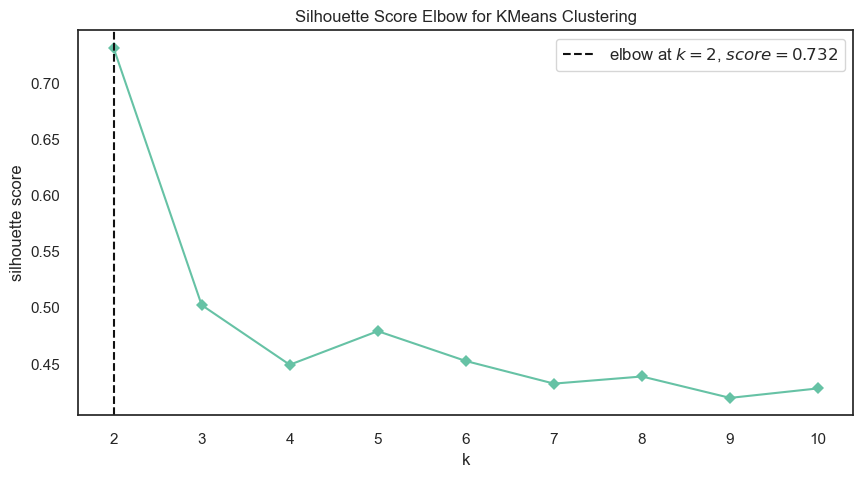

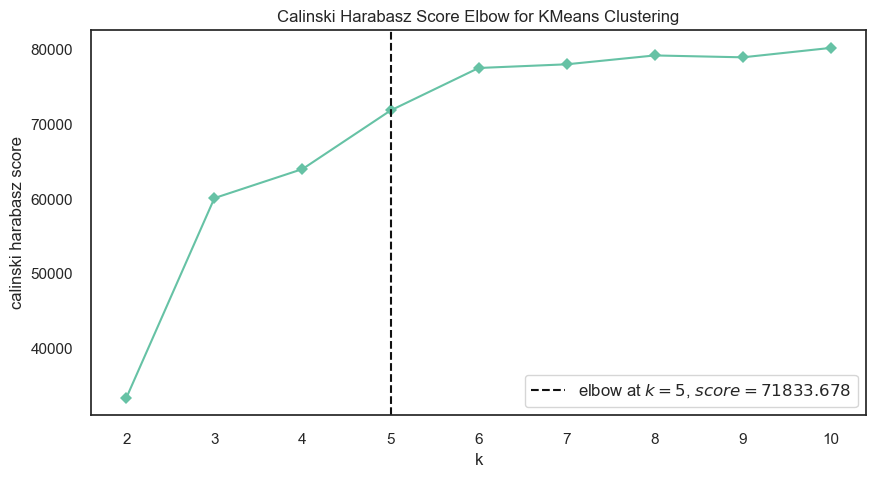

In [37]:
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
# HYPERPARÁMETROS DEL MODELO
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------

kmin              = 1           #Límite inferior para explorar el número de grupos.
kmax              = 10          #Límite superior para explorar el número de grupos.
init              ='k-means++'  #Se define el método de inicialización. Otra opción válida es 'random'.
n_init            = 10          #Número de inicializaciones aleatorias. Al final scikit learn escoge aquel con la menor inercia 
                                #(i.e.: suma de cuadrados de distancias de cada punto a su centroide respectivo dentro de cada grupo, para todos los puntos). 
                                #https://scikit-learn.org/stable/modules/clustering.html
max_iter          = 300         #Número MÁXIMO de iteraciones para una sola ejecución.
random_seed       = 42          #Semilla aleatoria. Permite obtener los mismos resultados en cada ejecución.


model2 = KMeans(init=init,              #Se define el método de inicialización. 
               n_init=n_init,           #Número de inicializaciones aleatorias. Al final se escoge aquel con la menor inercia: sum( (x_i-centroide(x_i))^2 ). 
               max_iter=max_iter,       #Número MÁXIMO de iteraciones para una sola ejecución.
               random_state=random_seed)

for metric in ["distortion", "silhouette", "calinski_harabasz"]:  #Itere sobre las métricas que soporta KElbowVisualizer.
  
  #Este condicional permite adaptar el flujo pues dos de las métricas requieren al menos 2 grupos para que se puedan calcular.
  if metric=="silhouette" or metric=="calinski_harabasz":  
    kmin_ = max(2,kmin)
  else:
    kmin_ = kmin
  
  plt.figure(figsize=(10,5))   #Tamaño de la figura (ancho, alto).
  visualizer2 = KElbowVisualizer(estimator=model2, 
                                  k=(kmin_,kmax+1),     #Permite explorar valores de k entre [kmin_,kmax].
                                  metric=metric,        #Opciones:  "distortion", "silhouette", "calinski_harabasz"
                                  timings=False,          
                                  locate_elbow=True)   #Si esta opción se activa, ubica el codo con una línea punteada.
  visualizer2.fit(df_x_train)   #Ajusta los datos al visualizador.
  visualizer2.show()

In [38]:
#-------------------------------------------------------------------------------
#K-means
#-------------------------------------------------------------------------------
k = 5  #Número de grupos que se escogió después del análisis previo.

#Ahora se instancia el objeto para utilizar el agrupamiento con k-means.
#Para ver todas los opciones del constructor, consulte: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
#Nota: el algoritmo de k-means disponible en scikit-learn funciona únicamente con la distancia euclidiana.
#Si requiere aplicar k-means con otras métricas de distancia, puede consultar la librería PyClustering: https://github.com/annoviko/pyclustering
kmeans = KMeans(n_clusters   = k,            #Se define el número de grupos.
                init         = init,         #Se define el método de inicialización. Otra opción es 'random'
                n_init       = n_init,       #Número de inicializaciones aleatorias. 
                max_iter     = max_iter,     #Número MÁXIMO de iteraciones para una sola ejecución.
                random_state = random_seed)

#Hagamos el ajuste (i.e.: encontremos los centroides).
kmeans.fit(df_x_train)

#Revisemos los centroides de cada grupo.
centroides = kmeans.cluster_centers_
print('Centroides:', centroides)

Centroides: [[0.54854963 0.05270781]
 [0.67867482 0.9313187 ]
 [0.74442355 0.06489903]
 [0.33140276 0.05444413]
 [0.68005812 0.33975018]]


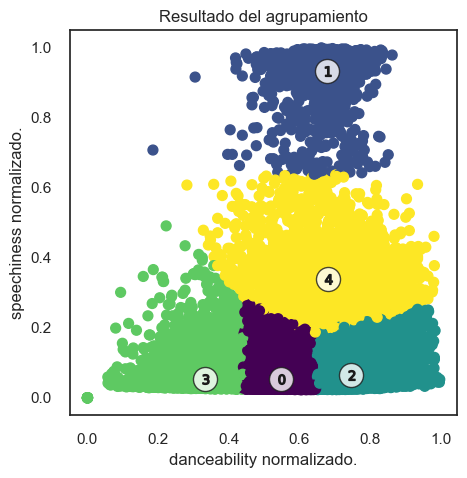

In [39]:
#Grafiquemos las observaciones y los centroides de cada grupo.
plt.figure(figsize=(5,5))
plt.scatter(df_x_train.iloc[:,0],   df_x_train.iloc[:,1], c=kmeans.labels_.reshape((-1,1)), s=50,  cmap='viridis')  #Observaciones.
plt.scatter(centroides[:, 0], centroides[:, 1], marker='o', color='white', edgecolor='k', s=300, alpha=0.8)       #Centroides.
plt.xlabel(df_x_train.columns[0]+' normalizado.')
plt.ylabel(df_x_train.columns[1]+' normalizado.')

#Esto permite identificar cada centroide con su índice asociado. 
for i, c in enumerate(centroides):
  plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

plt.title('Resultado del agrupamiento')
plt.show()

# **Evaluación del modelo**

**Coeficiente de Silueta (Silhouette coefficient):** Esta métrica calcula la cohesión y la separación de los grupos en función de la distancia intra-cluster y la distancia media más cercana entre los puntos de un cluster y los puntos de los clusters vecinos. El coeficiente de silueta varía entre -1 y 1, donde los valores más cercanos a 1 indican una buena calidad de clustering.

In [28]:
from sklearn.metrics import silhouette_score

# Calcula el coeficiente de silueta para los datos de entrenamiento
silhouette_avg = silhouette_score(df_x_train, kmeans.labels_)
print("Coeficiente de Silueta promedio:", silhouette_avg)


Coeficiente de Silueta promedio: 0.42053270268906606


**Índice de Calinski-Harabasz (Calinski-Harabasz index):** Esta métrica calcula la relación entre la dispersión dentro de los grupos y la dispersión entre los grupos. Puedes utilizar la función calinski_harabasz_score de scikit-learn para calcularlo.

In [29]:
from sklearn.metrics import calinski_harabasz_score

# Calcula el índice de Calinski-Harabasz para los datos de entrenamiento
ch_index = calinski_harabasz_score(df_x_train, kmeans.labels_)
print("Índice de Calinski-Harabasz:", ch_index)


Índice de Calinski-Harabasz: 223879.837178288


**Inercia (Distortion):** La inercia mide la suma de los cuadrados de las distancias de cada punto a su centroide más cercano. Puedes obtener este valor utilizando el atributo 

In [30]:
inertia = kmeans.inertia_
print("Inercia:", inertia)


Inercia: 3206.9931303010694


# **Despliegue del modelo**

**Streamlit:** 
Streamlit es una biblioteca de Python que permite crear aplicaciones web interactivas y visualizaciones de datos de forma rápida y sencilla. Está diseñada esencialmente para facilitar el desarrollo de interfaces de usuario (UI) para proyectos de ciencia de datos y aprendizaje automático, en la fase de despliegue.

In [40]:
#Importamos la libreria joblib para guardar el modelo
import joblib

#Guardamos el modelo en el archivo kmeans.joblib
joblib.dump(kmeans, 'kmeans.joblib')

['kmeans.joblib']